In [8]:
import librosa
from librosa.display import specshow
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

from bayesian_nls import bayesian_nls

sr = 16000
window_size = int(sr * 0.025)
hop_size = int(sr * 0.01)

cleen_speech, _ = librosa.load('fastf0/CleanSpeech.wav', sr=sr)
vib_flute, _ = librosa.load('fastf0/vib_flute.wav', sr=sr)
factory_noise = loadmat('fastf0/factoryNoise.mat')['factoryNoise']
factory_noise = np.squeeze(factory_noise)

def addnoise(sig, input_noise, snr):
    noise = input_noise
    noise_std_var = np.sqrt(10 ** (-snr * 0.1) * (sig @ sig) /(noise @ noise))
    output_noise = noise_std_var * noise
    return output_noise

def result_display(result, signal, freq_max=500):
    pitch, voicing, order = result[:, 0], result[:, 1], result[:, 2]
    mask = voicing < 0.5
    pitch[mask] = np.nan
    order[mask] = np.nan

    fig = plt.figure(figsize=(12, 10))
    ax = plt.subplot(4, 1, 4)
    time = np.arange(signal.shape[0]) / sr
    plt.plot(time, signal / np.abs(signal).max())
    plt.xlim(0, time.max())
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    S = librosa.stft(signal, win_length=window_size,
                     hop_length=hop_size)
    S = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    S = np.maximum(S, S.max() - 60)

    plt.subplot(4, 1, 3, sharex=ax)
    specshow(S, y_axis='linear', x_axis='time', sr=sr, hop_length=hop_size, cmap='viridis')
    timeVector = np.arange(result.shape[0]) * hop_size / sr
    plt.plot(timeVector, pitch, 'r-', linewidth=4)
    plt.ylim(0, freq_max)
    plt.ylabel('Frequency')
    plt.xlabel('')
    plt.subplot(4, 1, 2, sharex=ax)
    plt.plot(timeVector, order, 'r.', linewidth=4)
    plt.ylim(0, np.nanmax(order))
    plt.ylabel('Order estimate')
    plt.subplot(4, 1, 1, sharex=ax)
    plt.plot(timeVector, voicing, 'r-', linewidth=4)
    plt.ylabel('Voicing probability')
    plt.show()


## White Noise

  6%|▋         | 37/583 [00:00<00:01, 363.00it/s]/home/joey_yu/PycharmProjects/bayesian_pitchtrack/bayesian_nls.py:156: RuntimeWarning: divide by zero encountered in log
  bar_alpha = np.log(state_prior) + self.pitch_ll
100%|██████████| 583/583 [00:01<00:00, 415.54it/s]


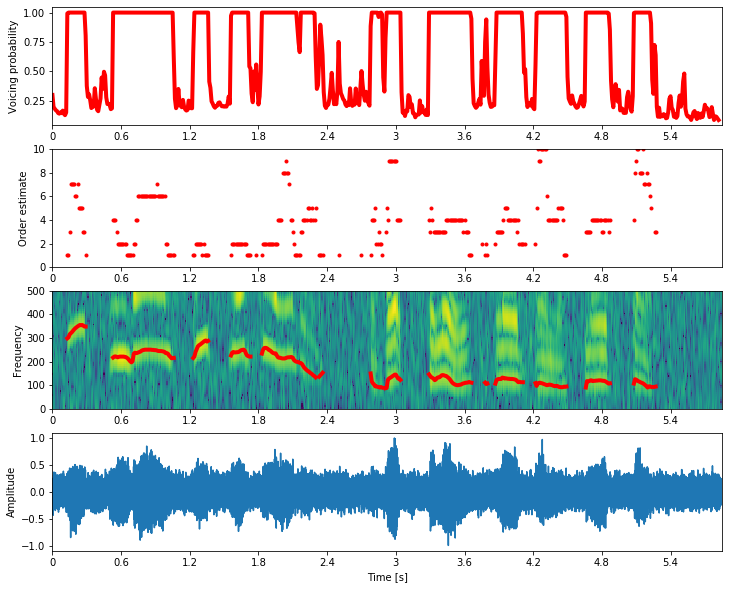

In [9]:
SNR = 0
noisy_signal = cleen_speech + addnoise(cleen_speech,
                                       np.random.randn(*cleen_speech.shape),
                                       SNR)

result = bayesian_nls(noisy_signal, sr, window_size, hop_size, max_order=10)
result_display(result, noisy_signal)

## Factory Noise

  0%|          | 0/583 [00:00<?, ?it/s]/home/joey_yu/PycharmProjects/bayesian_pitchtrack/bayesian_nls.py:145: RuntimeWarning: invalid value encountered in log1p
  gHat * (1 - self.cost_matrix)) + 0.5 * np.log(2 * math.pi * tauVar)
  3%|▎         | 15/583 [00:00<00:04, 140.44it/s]/home/joey_yu/PycharmProjects/bayesian_pitchtrack/bayesian_nls.py:156: RuntimeWarning: divide by zero encountered in log
  bar_alpha = np.log(state_prior) + self.pitch_ll
100%|██████████| 583/583 [00:04<00:00, 132.21it/s]


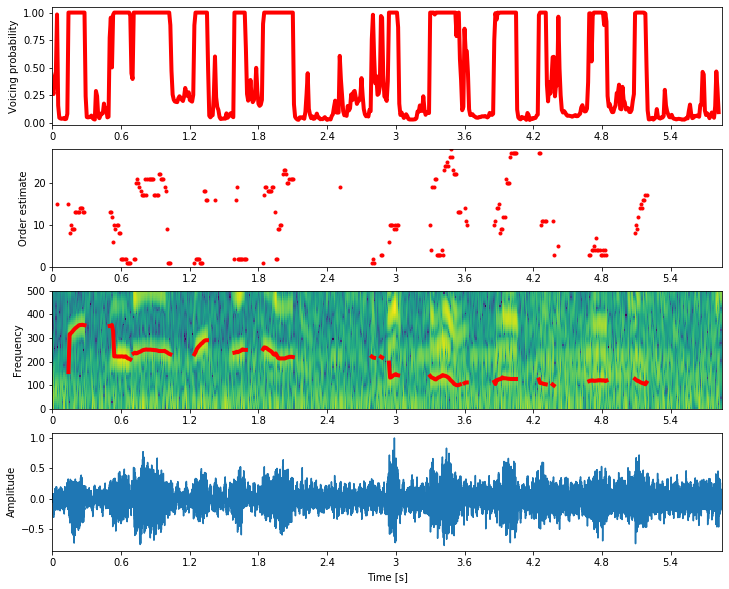

In [10]:
randstart = np.random.randint(0, len(factory_noise) - len(cleen_speech) - 100)
noise_seg = factory_noise[randstart:randstart + len(cleen_speech)]
noisy_signal = cleen_speech + addnoise(cleen_speech,
                                       noise_seg,
                                       SNR)

result = bayesian_nls(noisy_signal, sr, window_size, hop_size,
                      max_order=30, prew=True)
result_display(result, noisy_signal)

## Music

  0%|          | 0/2999 [00:00<?, ?it/s]/home/joey_yu/PycharmProjects/bayesian_pitchtrack/bayesian_nls.py:145: RuntimeWarning: invalid value encountered in log1p
  gHat * (1 - self.cost_matrix)) + 0.5 * np.log(2 * math.pi * tauVar)
  1%|▏         | 39/2999 [00:00<00:15, 188.45it/s]/home/joey_yu/PycharmProjects/bayesian_pitchtrack/bayesian_nls.py:156: RuntimeWarning: divide by zero encountered in log
  bar_alpha = np.log(state_prior) + self.pitch_ll
100%|██████████| 2999/2999 [00:17<00:00, 172.17it/s]


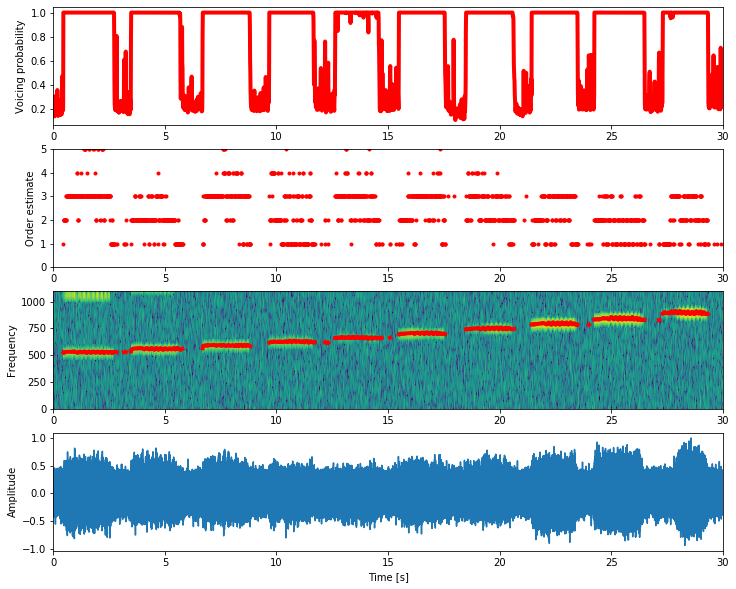

In [11]:
noisy_signal = vib_flute + addnoise(vib_flute,
                                       np.random.randn(*vib_flute.shape),
                                       SNR)

result = bayesian_nls(noisy_signal, sr, window_size, hop_size,
                      max_order=10, min_freq=100, max_freq=1000)
result_display(result, noisy_signal, 1100)

## Using Harmonic Summation Cost Function

Redo the above example but replace the cost function with (18) from the paper
[__Fast Nonlinear Least Squares Estimation of the Fundamental Frequency__](https://github.com/jkjaer/fastF0Nls).


$$J_{NLS}(\omega_0, l) = \boldsymbol{x}^T\boldsymbol{Z_l(\omega_0)}[\boldsymbol{Z}_l^T(\omega_0)\boldsymbol{Z}_l(\omega_0)]^{-1}\boldsymbol{Z}_l^T(\omega_0)\boldsymbol{x}$$
$$\eqsim J_{HS}(\omega_0, l) = ||\boldsymbol{Z}_l^T(\omega_0)\boldsymbol{x}||_2^2$$

  0%|          | 0/583 [00:00<?, ?it/s]/home/joey_yu/PycharmProjects/bayesian_pitchtrack/bayesian_nls.py:156: RuntimeWarning: divide by zero encountered in log
  bar_alpha = np.log(state_prior) + self.pitch_ll
100%|██████████| 583/583 [00:00<00:00, 727.88it/s]


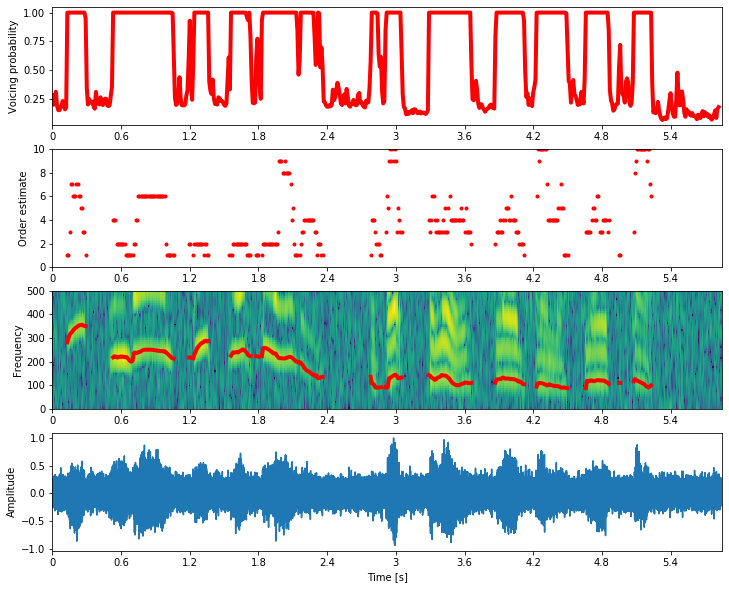

In [12]:
SNR = 0
noisy_signal = cleen_speech + addnoise(cleen_speech,
                                       np.random.randn(*cleen_speech.shape),
                                       SNR)

result = bayesian_nls(noisy_signal, sr, window_size, hop_size, max_order=10, cost_function='hs')
result_display(result, noisy_signal)



  0%|          | 0/583 [00:00<?, ?it/s]/home/joey_yu/PycharmProjects/bayesian_pitchtrack/bayesian_nls.py:156: RuntimeWarning: divide by zero encountered in log
  bar_alpha = np.log(state_prior) + self.pitch_ll
100%|██████████| 583/583 [00:01<00:00, 404.36it/s]


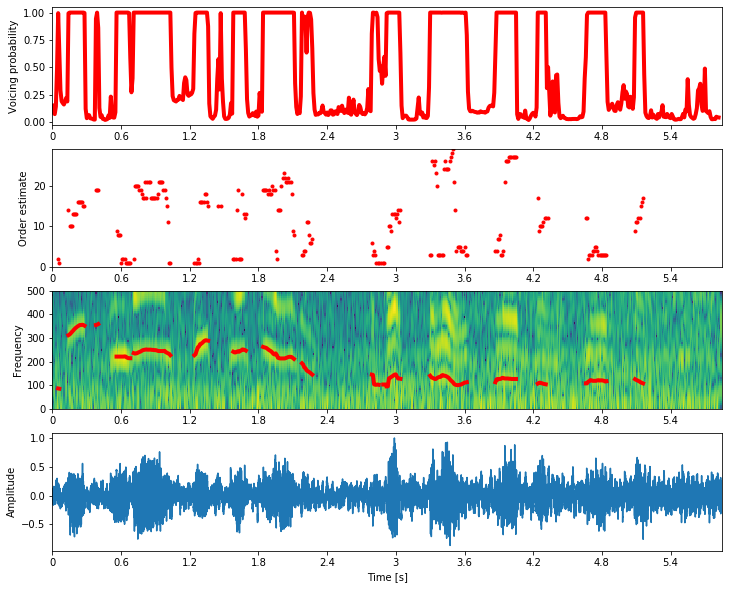

In [13]:
randstart = np.random.randint(0, len(factory_noise) - len(cleen_speech) - 100)
noise_seg = factory_noise[randstart:randstart + len(cleen_speech)]
noisy_signal = cleen_speech + addnoise(cleen_speech,
                                       noise_seg,
                                       SNR)

result = bayesian_nls(noisy_signal, sr, window_size, hop_size,
                      max_order=30, prew=True, cost_function='hs')
result_display(result, noisy_signal)

  1%|▏         | 40/2999 [00:00<00:07, 398.26it/s]/home/joey_yu/PycharmProjects/bayesian_pitchtrack/bayesian_nls.py:156: RuntimeWarning: divide by zero encountered in log
  bar_alpha = np.log(state_prior) + self.pitch_ll
100%|██████████| 2999/2999 [00:11<00:00, 255.67it/s]


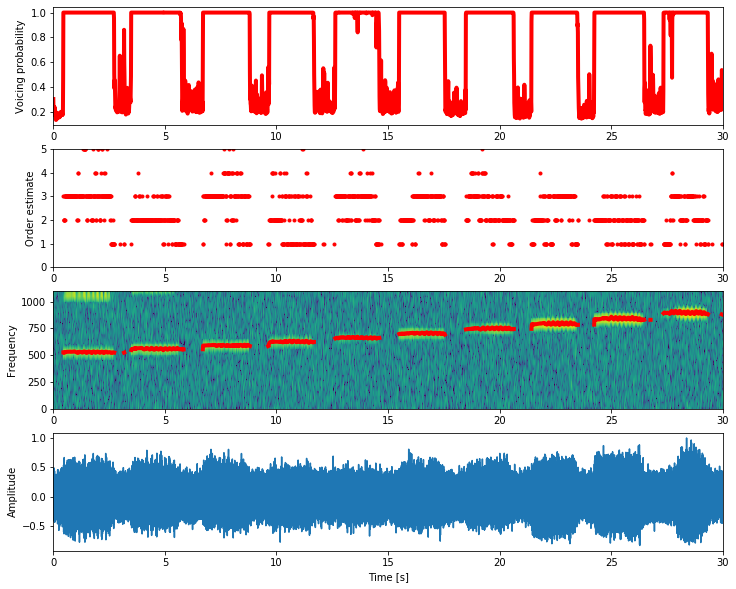

In [14]:
noisy_signal = vib_flute + addnoise(vib_flute,
                                       np.random.randn(*vib_flute.shape),
                                       SNR)

result = bayesian_nls(noisy_signal, sr, window_size, hop_size,
                      max_order=10, min_freq=100, max_freq=1000, cost_function='hs')
result_display(result, noisy_signal, 1100)